## Dataset Exploration Results

**Summary:**  
The file `exploration_summary.txt` contains:
- Total images, train/test splits
- Genuine vs. Forge counts
- Corrupt and blank image counts
- Min, max, and median image dimensions
- Number of test signers

**Visualizations:**  
Saved in `exploration_figures`:
1. Image width distribution
2. Image height distribution
3. Genuine vs. Forge counts
4. Test set: Genuine vs. Forge per signer (first 20)

**Purpose:**  
- Understand dataset quality and structure  
- Identify corrupt/blank images  
- Check label distribution before preprocessing/GAN training  

**Next Step:**  
- Clean and preprocess images for GAN training


In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

DATASET_PATH = '/content/drive/MyDrive/GPDS 1-150'
REPORT_DIR = os.path.join(DATASET_PATH, "exploration_reports")
FIG_DIR = os.path.join(DATASET_PATH, "exploration_figures")

os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

IMG_EXTS = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

def is_image_file(p: Path):
    return p.suffix.lower() in IMG_EXTS

def safe_open_image(path):
    try:
        with Image.open(path) as im:
            return im.convert('L')
    except:
        return None

def explore_split(split_path, split_name):
    rows = []
    for root, dirs, files in os.walk(split_path):
        for fn in files:
            p = Path(root) / fn
            if not is_image_file(p):
                continue

            # Determine type
            if "genuine" in root.lower():
                label_type = "genuine"
            elif "forg" in root.lower():
                label_type = "forge"
            else:
                label_type = None

            # Signer ID (only in test split)
            signer = None
            if split_name == "test":
                parts = Path(root).parts
                for prt in parts:
                    if prt.isdigit():
                        signer = prt
                        break

            im = safe_open_image(p)
            if im is None:
                rows.append({
                    "split": split_name, "signer": signer, "type": label_type,
                    "file_path": str(p), "is_corrupt": True
                })
                continue

            w, h = im.size
            arr = np.array(im)
            # blank image check
            pct_white = (arr > 250).sum() / arr.size
            pct_black = (arr < 5).sum() / arr.size
            is_blank = (pct_white > 0.98) or (pct_black > 0.98)

            rows.append({
                "split": split_name, "signer": signer, "type": label_type,
                "file_path": str(p), "is_corrupt": False,
                "width": w, "height": h, "is_blank": is_blank
            })
    return pd.DataFrame(rows)

# === Run exploration ===
train_df = explore_split(os.path.join(DATASET_PATH, "train"), "train")
test_df  = explore_split(os.path.join(DATASET_PATH, "test"), "test")
meta = pd.concat([train_df, test_df], ignore_index=True)

# Save CSV
meta.to_csv(os.path.join(REPORT_DIR, "exploration_meta.csv"), index=False)
print("Saved metadata CSV")

# === Summary ===
summary = {
    "total_images": len(meta),
    "train_genuine": int((train_df['type']=="genuine").sum()),
    "train_forge": int((train_df['type']=="forge").sum()),
    "test_genuine": int((test_df['type']=="genuine").sum()),
    "test_forge": int((test_df['type']=="forge").sum()),
    "num_signers_test": test_df['signer'].nunique(),
    "corrupt_images": int(meta['is_corrupt'].sum()),
    "blank_images": int(meta['is_blank'].sum()),
    "min_width": int(meta['width'].min()),
    "max_width": int(meta['width'].max()),
    "median_width": int(meta['width'].median()),
    "min_height": int(meta['height'].min()),
    "max_height": int(meta['height'].max()),
    "median_height": int(meta['height'].median())
}
with open(os.path.join(REPORT_DIR, "exploration_summary.txt"), "w") as f:
    for k,v in summary.items():
        f.write(f"{k}: {v}\n")
print("Saved summary TXT")

# === Visualization ===
# Width distribution
plt.hist(meta['width'].dropna(), bins=30)
plt.title("Image Width Distribution")
plt.savefig(os.path.join(FIG_DIR, "width_distribution.png"))
plt.close()

# Height distribution
plt.hist(meta['height'].dropna(), bins=30)
plt.title("Image Height Distribution")
plt.savefig(os.path.join(FIG_DIR, "height_distribution.png"))
plt.close()

# Genuine vs Forge counts
meta['type'].value_counts().plot(kind="bar", title="Genuine vs Forge counts")
plt.savefig(os.path.join(FIG_DIR, "genuine_vs_forge.png"))
plt.close()

# Images per signer (test set only)
signer_counts = test_df.groupby(["signer","type"]).size().unstack(fill_value=0)
signer_counts.head(20).plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Test set: Genuine vs Forge per signer (first 20)")
plt.savefig(os.path.join(FIG_DIR, "signer_distribution.png"))
plt.close()

print("Saved all figures to", FIG_DIR)

===== Dataset Summary =====

total_images: 8100
train_genuine: 2400
train_forge: 2400
test_genuine: 1200
test_forge: 2100
num_signers_test: 150
corrupt_images: 0
blank_images: 99
min_width: 594
max_width: 2880
median_width: 1282
min_height: 514
max_height: 1591
median_height: 783


===== Displaying all saved figures =====



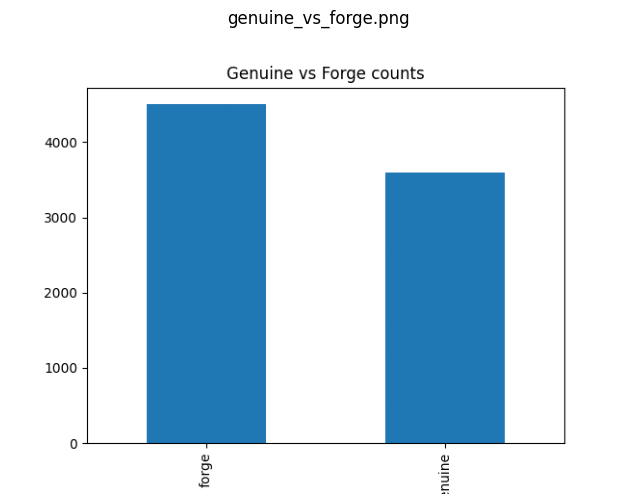

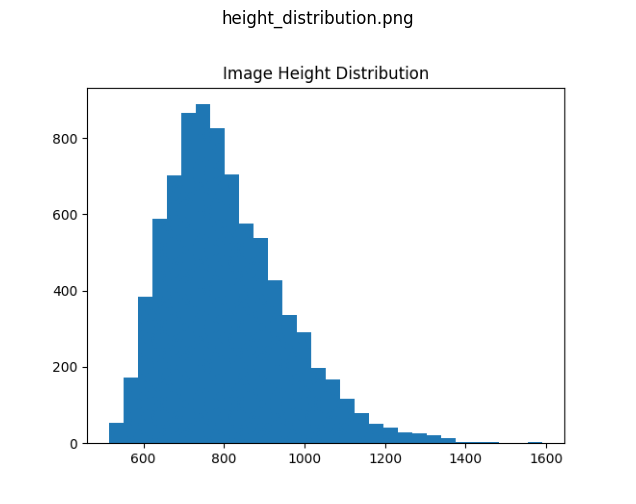

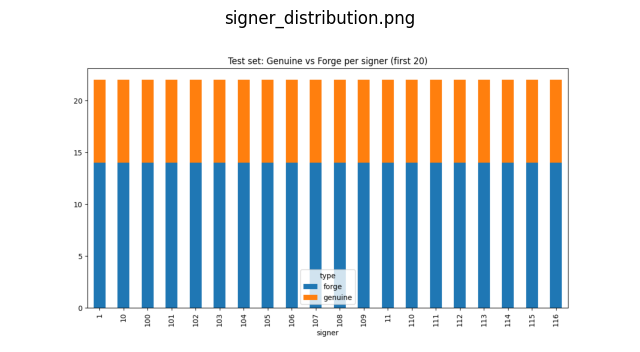

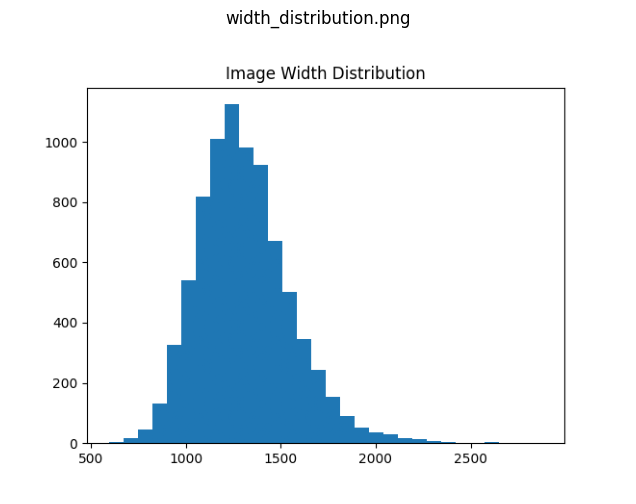

In [ ]:
# Output The Results

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths
FIG_DIR = "/content/drive/MyDrive/GPDS 1-150/exploration_figures"
SUMMARY_PATH = "/content/drive/MyDrive/GPDS 1-150/exploration_reports/exploration_summary.txt"

# --- Print summary.txt ---
print("===== Dataset Summary =====\n")
with open(SUMMARY_PATH, "r") as f:
    print(f.read())

# --- Display all images in exploration_figures ---
print("\n===== Displaying all saved figures =====\n")
fig_files = sorted([f for f in os.listdir(FIG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

for fig_file in fig_files:
    img_path = os.path.join(FIG_DIR, fig_file)
    img = mpimg.imread(img_path)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(fig_file)
    plt.show()


# GAN Dataset Preprocessing (GPDS 1-150)

### Goal
Prepare GPDS 1-150 for **GAN training** with clean, sharp, standardized images.

---

### Pipeline

1. **Grayscale Conversion**
   - Convert all images to grayscale.

2. **Binarization / Stroke Enhancement**
   - Adaptive thresholding → ink strokes black, background white.
   - Improves contrast & stroke clarity.

3. **Noise Removal & Enhancement**
   - Median filter → remove noise.  
   - Morphological opening → clean small dots.  
   - CLAHE → boost local contrast.  
   - Unsharp masking → sharpen strokes.

4. **Center-Crop / Padding + Resize**
   - Pad to square, resize all images to **256×256**.

5. **Near-Blank Removal**
   - Skip images with very few ink pixels.

7. **Save to Google Drive**
   - All processed images saved in:  
     `/content/drive/MyDrive/GPDS 1-150/Binarized`

---

### Outcome
- Clean, sharp, binarized signatures.  
- Consistent size `256×256`.  
- Noise-free and ready for GAN training.


In [ ]:
# @title
import os
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import shutil

# === USER CONFIG ===
DATASET_PATH = '/content/drive/MyDrive/GPDS 1-150'       # original dataset
PROCESSED_PATH = '/content/drive/MyDrive/GPDS 1-150/Preprocessed'
TARGET_SIZE = 256  # target image size (square)
MIN_FILL = 0.02    # min percentage of ink pixels to keep (remove near-blank)

os.makedirs(PROCESSED_PATH, exist_ok=True)

IMG_EXTS = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

def is_image_file(path: Path):
    return path.suffix.lower() in IMG_EXTS

def process_image(path: Path, target_size=TARGET_SIZE):
    """Open, grayscale, center-crop/pad to square, optional adaptive threshold."""
    try:
        im = Image.open(path).convert('L')  # grayscale
        # center crop/pad to square
        w, h = im.size
        max_dim = max(w, h)
        new_im = Image.new('L', (max_dim, max_dim), 255)  # white background
        new_im.paste(im, ((max_dim - w)//2, (max_dim - h)//2))
        new_im = new_im.resize((target_size, target_size), Image.Resampling.LANCZOS)

        # check blank image
        arr = np.array(new_im)
        pct_white = (arr > 250).sum() / arr.size
        if pct_white > 1 - MIN_FILL:
            return None  # too blank, skip

        return new_im
    except:
        return None

def preprocess_split(split_folder, save_root):
    """Preprocess all images in a split (train/test) and save immediately."""
    for root, dirs, files in os.walk(split_folder):
        for fn in files:
            path = Path(root) / fn
            if not is_image_file(path):
                continue

            # determine relative path for saving (keep folder structure)
            rel_path = Path(root).relative_to(split_folder)
            save_dir = Path(save_root) / rel_path
            save_dir.mkdir(parents=True, exist_ok=True)

            proc_im = process_image(path)
            if proc_im is not None:
                save_path = save_dir / fn
                proc_im.save(save_path)

# === RUN PREPROCESSING ===
print("Preprocessing TRAIN split...")
preprocess_split(os.path.join(DATASET_PATH, "train"), os.path.join(PROCESSED_PATH, "train"))
print("Preprocessing TEST split...")
preprocess_split(os.path.join(DATASET_PATH, "test"), os.path.join(PROCESSED_PATH, "test"))
print("All images preprocessed and saved to Google Drive!")


In [ ]:
# @title
# Exploring Preprocessed Folder

import os

PROCESSED_PATH = '/content/drive/MyDrive/GPDS 1-150/Preprocessed'

def count_images_seq(root_path):
    total_count = 0
    for split in ['train', 'test']:  # process in order
        split_path = os.path.join(root_path, split)
        if not os.path.isdir(split_path):
            continue
        print(f"\n=== {split.upper()} SPLIT ===")
        split_total = 0

        if split == 'train':
            # train: genuine/forge → images
            for category in ['genuine', 'forge']:
                cat_path = os.path.join(split_path, category)
                if not os.path.isdir(cat_path):
                    continue
                n_images = len([f for f in os.listdir(cat_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
                print(f"{category}: {n_images} images")
                split_total += n_images
        else:
            # test: signer → genuine/forge → images
            for signer in sorted(os.listdir(split_path), key=lambda x: int(x) if x.isdigit() else x):
                signer_path = os.path.join(split_path, signer)
                if not os.path.isdir(signer_path):
                    continue
                signer_total = 0
                print(f"Signer: {signer}")
                for category in ['genuine','forge']:
                    cat_path = os.path.join(signer_path, category)
                    if not os.path.isdir(cat_path):
                        continue
                    n_images = len([f for f in os.listdir(cat_path) if f.lower().endswith(('.png','.jpg','.jpeg'))])
                    print(f"  {category}: {n_images} images")
                    signer_total += n_images
                print(f"  Total images for signer {signer}: {signer_total}")
                split_total += signer_total

        print(f"Total images in {split} split: {split_total}")
        total_count += split_total

    print(f"\nGrand total images in Preprocessed dataset: {total_count}")

count_images_seq(PROCESSED_PATH)


In [ ]:
# @title
import matplotlib.pyplot as plt

# Example: total images per signer (test split)
signer_counts = []
split_path = os.path.join(PROCESSED_PATH, "test")
for signer in sorted(os.listdir(split_path)):
    signer_path = os.path.join(split_path, signer)
    total_imgs = sum(len([f for f in os.listdir(os.path.join(signer_path, l))
                          if f.lower().endswith(('.png','.jpg','.jpeg'))])
                     for l in ['genuine','forge'] if os.path.exists(os.path.join(signer_path, l)))
    signer_counts.append(total_imgs)

plt.figure(figsize=(15,5))
plt.bar(range(1,len(signer_counts)+1), signer_counts)
plt.xlabel("Signer ID (test split)")
plt.ylabel("Total images")
plt.title("Images per signer")
plt.show()


In [3]:
import os
from PIL import Image
import numpy as np
import cv2
from scipy.ndimage import uniform_filter, median_filter, gaussian_filter

# === PATH CONFIG ===
PROCESSED_PATH = '/content/drive/MyDrive/GPDS 1-150/Preprocessed'
BINARIZED_PATH = '/content/drive/MyDrive/GPDS 1-150/Binarized'

os.makedirs(BINARIZED_PATH, exist_ok=True)

# === BINARIZATION FUNCTION ===
def binarize_image(img, block_size=15, C=10):
    """Adaptive thresholding: strokes -> black, background -> white"""
    arr = np.array(img)
    local_mean = uniform_filter(arr, size=block_size)
    binary_arr = np.where(arr < (local_mean - C), 0, 255)
    return binary_arr.astype(np.uint8)

# === ENHANCEMENT FUNCTION ===
def enhance_image(img_arr, target_size=(128, 128)):
    # Step 1: Median filter (noise removal)
    img = median_filter(img_arr, size=3)

    # Step 2: Morphological opening (remove small dots)
    kernel = np.ones((2,2), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # Step 3: CLAHE (local contrast enhancement)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Step 4: Sharpen (Unsharp Masking)
    blurred = gaussian_filter(img, sigma=1)
    img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)

    # Step 5: Resize
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    return img

# === PROCESS FUNCTION ===
def process_preprocessed(input_root, output_root):
    for split in ["train", "test"]:
        split_path = os.path.join(input_root, split)
        for root, dirs, files in os.walk(split_path):
            # Maintain same relative path in output folder
            rel_path = os.path.relpath(root, input_root)
            save_dir = os.path.join(output_root, rel_path)
            os.makedirs(save_dir, exist_ok=True)

            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(save_dir, file)

                    try:
                        # Open grayscale
                        im = Image.open(src_path).convert('L')
                        # Step 1: Binarize
                        bin_im = binarize_image(im)
                        # Step 2: Enhance
                        enh_img = enhance_image(bin_im)
                        # Save result
                        cv2.imwrite(dst_path, enh_img)
                    except Exception as e:
                        print(f"Skipping {src_path}: {e}")

        print(f"Processed {split} split")

# === RUN ===
print("Binarizing + Enhancing Preprocessed dataset → saving in Binarized folder...")
process_preprocessed(PROCESSED_PATH, BINARIZED_PATH)
print("All binarized & enhanced images saved in:", BINARIZED_PATH)


Binarizing + Enhancing Preprocessed dataset → saving in Binarized folder...
Skipping /content/drive/MyDrive/GPDS 1-150/Preprocessed/train/genuine/c-094-14 (Copy).jpg: cannot identify image file '/content/drive/MyDrive/GPDS 1-150/Preprocessed/train/genuine/c-094-14 (Copy).jpg'
Processed train split
Processed test split
All binarized & enhanced images saved in: /content/drive/MyDrive/GPDS 1-150/Binarized


In [11]:
import os
import random
from pathlib import Path
from PIL import Image
from collections import defaultdict

BINARIZED_PATH = Path('/content/drive/MyDrive/GPDS 1-150/Binarized')
TARGET_SIZE = (128, 128)   # fix size
KEEP_RATIO = 0.5           # keep 50% images
REDUCED_PATH = Path('/content/drive/MyDrive/GPDS 1-150/Final_Dataset')

os.makedirs(REDUCED_PATH, exist_ok=True)

def resize_and_reduce(root, target_root, target_size=(128,128), keep_ratio=0.5):
    stats = defaultdict(int)

    for split in ["train", "test"]:
        split_path = root / split
        if not split_path.exists():
            continue

        for signer in split_path.rglob("*"):
            if signer.is_dir():
                rel_path = signer.relative_to(root)
                save_dir = target_root / rel_path
                os.makedirs(save_dir, exist_ok=True)

                files = [f for f in signer.iterdir() if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]
                if not files:
                    continue

                # Randomly keep a fraction
                keep_n = max(1, int(len(files) * keep_ratio))
                keep_files = random.sample(files, keep_n)

                for file in keep_files:
                    try:
                        img = Image.open(file).convert("L")
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(save_dir / file.name)
                        stats[str(rel_path)] += 1
                    except Exception as e:
                        print(f"⚠️ Error {file}: {e}")

                print(f"Processed {len(keep_files)}/{len(files)} images in {rel_path}")

    return stats

# === Run Processing ===
print("Resizing & reducing dataset...")
stats = resize_and_reduce(BINARIZED_PATH, REDUCED_PATH, target_size=TARGET_SIZE, keep_ratio=KEEP_RATIO)

# === Summary ===
print("\n=== Dataset Summary ===")
total_train = sum(v for k, v in stats.items() if k.startswith("train"))
total_test = sum(v for k, v in stats.items() if k.startswith("test"))
print(f"Total Train: {total_train}")
print(f"Total Test: {total_test}")
print(f"Grand Total: {total_train + total_test}")

print("\nPer-folder counts:")
for folder, count in stats.items():
    print(f"{folder}: {count} images")


Resizing & reducing dataset...
Processed 4620/9240 images in train/genuine
Processed 4566/9132 images in train/forge
Processed 16/32 images in test/98/genuine
Processed 28/56 images in test/98/forge
Processed 16/32 images in test/97/genuine
Processed 28/56 images in test/97/forge
Processed 16/32 images in test/93/genuine
Processed 28/56 images in test/93/forge
Processed 16/32 images in test/99/genuine
Processed 26/52 images in test/99/forge
Processed 16/32 images in test/96/genuine
Processed 28/56 images in test/96/forge
Processed 16/32 images in test/91/genuine
Processed 28/56 images in test/91/forge
Processed 14/28 images in test/92/genuine
Processed 28/56 images in test/92/forge
Processed 16/32 images in test/95/genuine
Processed 26/52 images in test/95/forge
Processed 14/28 images in test/94/genuine
Processed 28/56 images in test/94/forge
Processed 10/20 images in test/90/genuine
Processed 16/32 images in test/90/forge
Processed 16/32 images in test/89/genuine
Processed 28/56 image

In [13]:
# Code To Check Img Size

from PIL import Image

img_path = "/content/drive/MyDrive/GPDS 1-150/Final_Dataset/test/1/forge/cf-001-17 (Copy).jpg"

with Image.open(img_path) as img:
    print(f"Image size: {img.size}")   # (width, height)
    print(f"Mode: {img.mode}")        # e.g. 'L' (grayscale) ya 'RGB'

Image size: (128, 128)
Mode: L


In [15]:
# Count Total No Of Images

import os

DATASET_PATH = "/content/drive/MyDrive/GPDS 1-150/Final_Dataset"

count = 0
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            count += 1

print(f"✅ Total images found: {count}")


✅ Total images found: 15470


#AC-GAN for Realistic Signature Generation


## 🔹 Workflow

1. **Imports & Config** – Setup libraries, paths, and hyperparameters.  
2. **Dataset Loader** – Loads binarized/augmented signature images, assigns signer IDs, applies preprocessing (resize, normalize).  
3. **Generator (G)** – Takes random noise + signer ID (one-hot) and produces synthetic signatures.  
   - Uses *Conditional BatchNorm* for class conditioning.  
4. **Discriminator (D)** – Judges real/fake and predicts signer ID (auxiliary classifier).  
   - Uses adversarial + classification loss.  
5. **Training Loop** – Alternates updates between G and D.  
   - Loss = BCE (real/fake) + CrossEntropy (class).  
6. **Sampling** – Generates and saves synthetic signatures per signer for evaluation.  

##1. **Imports & Config** – Setup libraries, paths, and hyperparameters.  

In [4]:
# === Imports & Config ===
import os
import string
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# ---- Paths ----
DATA_ROOT = "/content/drive/MyDrive/GPDS 1-150/Final_Dataset"  # dataset root
SPLIT = "test"   # "train" or "test"

# ---- Hyperparameters ----
IMG_SIZE = 128       # ✅ enforce 128x128
BATCH_SIZE = 32
Z_DIM = 128          # latent noise dimension
G_LR = 2e-4          # generator learning rate
D_LR = 2e-4          # discriminator learning rate
BETA1, BETA2 = 0.5, 0.999  # Adam optimizer betas
NUM_EPOCHS = 50
SN = True            # spectral normalization in discriminator

# ---- Character-level Embedding ----
ALPHABET = string.ascii_lowercase + " "  # a-z + space
ALPHABET_SIZE = len(ALPHABET)
MAX_NAME_LEN = 20    # max characters in a name
EMBED_DIM = 32       # embedding dim per character
NAME_EMBED_DIM = 128 # ✅ final dense embedding size after GRU

# ---- Save directories ----
SAVE_DIR = "/content/drive/MyDrive/GPDS 1-150/checkpoints_acgan"
SAMPLE_DIR = "/content/drive/MyDrive/GPDS 1-150/samples_acgan"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

# ---- Device ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}, Alphabet size: {ALPHABET_SIZE}, "
      f"Max name length: {MAX_NAME_LEN}, Image size: {IMG_SIZE}, "
      f"Name embed dim: {NAME_EMBED_DIM}")


Device: cpu, Alphabet size: 27, Max name length: 20, Image size: 128, Name embed dim: 128


##2. **Dataset Loader** – Loads binarized/augmented signature images, assigns signer IDs, applies preprocessing (resize, normalize).  

In [5]:
# === Dataset Loader with Learned Embeddings (Fixed for DataLoader & CPU tensors) ===
class SignatureDataset(Dataset):
    """
    Loads signature images and encodes signer names using Embedding + GRU.
    Returns CPU tensors for DataLoader compatibility.
    """
    def __init__(self, root: str, split: str = "train", img_size: int = 128,
                 max_name_len: int = MAX_NAME_LEN, alphabet: str = ALPHABET,
                 embed_dim: int = EMBED_DIM, name_embed_dim: int = NAME_EMBED_DIM,
                 transforms_obj=None):

        self.root = Path(root) / split
        self.samples = []
        self.names = []
        self.max_name_len = max_name_len
        self.alphabet = alphabet
        self.char2idx = {c: i for i, c in enumerate(alphabet)}
        self.alphabet_size = len(alphabet)

        self._build_index()

        # Image transforms
        self.img_size = img_size
        self.transforms = transforms_obj or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        # Name encoder
        self.char_embedding = nn.Embedding(self.alphabet_size, embed_dim)
        self.gru = nn.GRU(embed_dim, name_embed_dim, batch_first=True)
        self.char_embedding.eval()
        self.gru.eval()

    def _build_index(self):
        signers = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        if not signers:
            raise ValueError(f"No signer folders found in {self.root}")

        for signer in signers:
            signer_path = self.root / signer
            for label_folder in signer_path.iterdir():
                if not label_folder.is_dir():
                    continue
                for img_file in label_folder.iterdir():
                    if img_file.suffix.lower() in ('.png', '.jpg', '.jpeg'):
                        self.samples.append(str(img_file))
                        self.names.append(signer.lower())

    def __len__(self):
        return len(self.samples)

    def _encode_name(self, name: str):
        """Convert name to dense embedding using Embedding + GRU (CPU)."""
        name = name.lower()[:self.max_name_len]
        idxs = torch.tensor([self.char2idx.get(c, 0) for c in name], dtype=torch.long)
        if len(idxs) < self.max_name_len:
            pad = torch.zeros(self.max_name_len - len(idxs), dtype=torch.long)
            idxs = torch.cat([idxs, pad], dim=0)

        idxs = idxs.unsqueeze(0)  # (1, max_len)
        with torch.no_grad():
            emb = self.char_embedding(idxs)  # (1, max_len, embed_dim)
            _, hidden = self.gru(emb)        # (1, 1, name_embed_dim)
        return hidden.squeeze(0).squeeze(0)  # (name_embed_dim,)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        name = self.names[idx]

        # Load and transform image (CPU)
        img = Image.open(img_path).convert('L')
        img = self.transforms(img)

        # Encode name (CPU)
        name_emb = self._encode_name(name)

        return img, name_emb


##3. **Generator (G)** – Takes random noise + signer ID (one-hot) and produces synthetic signatures.  

##4. **Discriminator (D)** – Judges real/fake and predicts signer ID (auxiliary classifier).  

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as SN

# === Spectral Normalized Conv Helper ===
def sn_conv(in_channels, out_channels, kernel_size, stride, padding):
    """Conv2d layer with spectral normalization."""
    return SN(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))

# === Conditional BatchNorm for Generator ===
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, embed_dim):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Linear(embed_dim, num_features * 2)
        nn.init.xavier_uniform_(self.embed.weight)

    def forward(self, x, embed):
        out = self.bn(x)
        params = self.embed(embed)
        gamma, beta = params.chunk(2, dim=1)
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)
        beta = beta.unsqueeze(-1).unsqueeze(-1)
        return gamma * out + beta

# === Generator with Dense Name Embedding (128x128) ===
# === Generator (Dense Name Embedding, 128x128) ===
class Generator(nn.Module):
    def __init__(self, z_dim, name_embed_dim=NAME_EMBED_DIM, base_channels=64, out_channels=1, img_size=128):
        super().__init__()
        self.img_size = img_size
        self.project = nn.Linear(z_dim + name_embed_dim, 4*4*base_channels*8)

        self.cbn1 = ConditionalBatchNorm2d(base_channels*8, name_embed_dim)
        self.cbn2 = ConditionalBatchNorm2d(base_channels*4, name_embed_dim)
        self.cbn3 = ConditionalBatchNorm2d(base_channels*2, name_embed_dim)
        self.cbn4 = ConditionalBatchNorm2d(base_channels, name_embed_dim)

        self.deconv_blocks = nn.ModuleList([
            nn.ConvTranspose2d(base_channels*8, base_channels*4, 4, 2, 1, bias=False),
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, 2, 1, bias=False),
            nn.ConvTranspose2d(base_channels*2, base_channels, 4, 2, 1, bias=False),
            nn.ConvTranspose2d(base_channels, base_channels//2, 4, 2, 1, bias=False),
            nn.ConvTranspose2d(base_channels//2, out_channels, 4, 2, 1, bias=False),
        ])

        self.activation = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, z, name_embed):
        x = torch.cat([z, name_embed], dim=1)
        x = self.project(x).view(x.size(0), -1, 4, 4)
        x = self.cbn1(x, name_embed)
        x = self.activation(x)

        x = self.deconv_blocks[0](x)
        x = self.cbn2(x, name_embed)
        x = self.activation(x)

        x = self.deconv_blocks[1](x)
        x = self.cbn3(x, name_embed)
        x = self.activation(x)

        x = self.deconv_blocks[2](x)
        x = self.cbn4(x, name_embed)
        x = self.activation(x)

        x = self.deconv_blocks[3](x)
        x = self.activation(x)

        x = self.deconv_blocks[4](x)
        return self.tanh(x)


# === Discriminator (Dense Name Embedding, 128x128) ===
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, name_embed_dim=NAME_EMBED_DIM, base_channels=64, img_size=128):
        super().__init__()
        self.img_size = img_size

        self.main = nn.Sequential(
            sn_conv(in_channels, base_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            sn_conv(base_channels, base_channels*2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            sn_conv(base_channels*2, base_channels*4, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            sn_conv(base_channels*4, base_channels*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            sn_conv(base_channels*8, base_channels*16, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Compute flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_size, img_size)
            feat = self.main(dummy)
            self.flattened_size = feat.view(1, -1).size(1)

        # Heads
        self.adv_head = sn_conv(base_channels*16, 1, 4, 1, 0)
        self.name_head = nn.Linear(self.flattened_size, name_embed_dim)

    def forward(self, x):
        feat = self.main(x)
        adv_out = self.adv_head(feat).view(-1)
        feat_flat = feat.view(feat.size(0), -1)
        name_out = self.name_head(feat_flat)
        return adv_out, name_out


##5. **Training Loop** – Alternates updates between G and D.  
   - Loss = BCE (real/fake) + CrossEntropy (class).  

In [31]:
def train_acgan_name_embeddings(save_every=5, sample_every=5):
    ds = SignatureDataset(root=DATA_ROOT, split=SPLIT, img_size=IMG_SIZE)
    print(f"Found {len(ds)} images, alphabet size: {ds.alphabet_size}, max name length: {ds.max_name_len}")

    # Use num_workers=0 to avoid CUDA fork issues
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

    name_emb_dim = NAME_EMBED_DIM  # ✅ Use dense embedding size

    G = Generator(Z_DIM, name_emb_dim, img_size=IMG_SIZE).to(DEVICE)
    D = Discriminator(in_channels=1, name_embed_dim=name_emb_dim, img_size=IMG_SIZE).to(DEVICE)

    optG = torch.optim.Adam(G.parameters(), lr=G_LR, betas=(BETA1, BETA2))
    optD = torch.optim.Adam(D.parameters(), lr=D_LR, betas=(BETA1, BETA2))

    adv_criterion = nn.BCEWithLogitsLoss()
    class_criterion = nn.MSELoss()  # dense embedding consistency

    start_epoch = 0
    g_ckpts = sorted(Path(SAVE_DIR).glob("G_epoch_*.pth"))
    d_ckpts = sorted(Path(SAVE_DIR).glob("D_epoch_*.pth"))

    # ✅ Add check for name encoder checkpoints to resume properly
    encoder_ckpts = sorted(Path(SAVE_DIR).glob("name_encoder_epoch_*.pth"))

    if g_ckpts and d_ckpts and encoder_ckpts:
        last_g = g_ckpts[-1]
        last_d = d_ckpts[-1]
        last_encoder = encoder_ckpts[-1]

        G.load_state_dict(torch.load(last_g, map_location=DEVICE))
        D.load_state_dict(torch.load(last_d, map_location=DEVICE))

        # Load the name encoder's weights
        encoder_state = torch.load(last_encoder, map_location=DEVICE)
        ds.char_embedding.load_state_dict(encoder_state['char_embedding'])
        ds.gru.load_state_dict(encoder_state['gru'])

        start_epoch = int(last_g.stem.split("_")[-1])
        print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, NUM_EPOCHS):
        for imgs, name_embs in loader:
            imgs, name_embs = imgs.to(DEVICE), name_embs.to(DEVICE)
            bsize = imgs.size(0)

            real_targets = torch.ones(bsize, device=DEVICE)
            fake_targets = torch.zeros(bsize, device=DEVICE)

            # Train Discriminator
            z = torch.randn(bsize, Z_DIM, device=DEVICE)
            fake_imgs = G(z, name_embs).detach()
            adv_real, name_real = D(imgs)
            adv_fake, name_fake = D(fake_imgs)
            lossD_adv = adv_criterion(adv_real, real_targets) + adv_criterion(adv_fake, fake_targets)
            lossD_name = class_criterion(name_real, name_embs)
            lossD = lossD_adv + 0.5 * lossD_name

            optD.zero_grad()
            lossD.backward()
            optD.step()

            # Train Generator
            z = torch.randn(bsize, Z_DIM, device=DEVICE)
            gen_imgs = G(z, name_embs)
            adv_out, name_out = D(gen_imgs)
            lossG_adv = adv_criterion(adv_out, real_targets)
            lossG_name = class_criterion(name_out, name_embs)
            lossG = lossG_adv + 0.5 * lossG_name

            optG.zero_grad()
            lossG.backward()
            optG.step()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LossD: {lossD.item():.4f} | LossG: {lossG.item():.4f} | "
              f"(D_adv: {lossD_adv.item():.4f}, D_name: {lossD_name.item():.4f}, "
              f"G_adv: {lossG_adv.item():.4f}, G_name: {lossG_name.item():.4f})")

        if (epoch + 1) % save_every == 0:
            torch.save(G.state_dict(), f"{SAVE_DIR}/G_epoch_{epoch+1}.pth")
            torch.save(D.state_dict(), f"{SAVE_DIR}/D_epoch_{epoch+1}.pth")

            # ✅ Add this to save the name encoder's weights
            torch.save({
                'char_embedding': ds.char_embedding.state_dict(),
                'gru': ds.gru.state_dict()
            }, f"{SAVE_DIR}/name_encoder_epoch_{epoch+1}.pth")

            print(f"✅ Saved checkpoints at epoch {epoch+1}")

        if (epoch + 1) % sample_every == 0:
            sample_names = ["malika", "arham", "krar"]
            sample_signatures_name(G, sample_names, epoch+1, n_per_name=4, ds=ds)

    torch.save(G.state_dict(), f"{SAVE_DIR}/G_final.pth")
    print("🎉 Training complete. Final generator saved as G_final.pth")

    # ✅ Add this to save the final name encoder weights
    torch.save({
        'char_embedding': ds.char_embedding.state_dict(),
        'gru': ds.gru.state_dict()
    }, f"{SAVE_DIR}/name_encoder_final.pth")
    print("🎉 Final name encoder saved as name_encoder_final.pth")

##6. **Sampling** – Generates and saves synthetic signatures per signer for evaluation.  

In [8]:
# === Sampling with Dense Name Embeddings (128x128) ===
from torchvision import transforms, utils

def sample_signatures_name(G, names: list, epoch: int = None, n_per_name: int = 4, ds: SignatureDataset = None):
    """
    Generate synthetic signatures for given names using the trained ACGAN.

    Args:
        G : Generator model
        names : list of strings (names to generate)
        epoch : int, optional, used in filename
        n_per_name : int, number of samples per name
        ds : SignatureDataset, used to encode names
    """
    assert ds is not None, "Pass the dataset object to encode names."

    # Encode names using dataset embedding (dense 128-dim)
    all_name_embs = []
    for name in names:
        name_emb = ds._encode_name(name.lower())  # still outputs dense vector
        all_name_embs.append(name_emb.unsqueeze(0).repeat(n_per_name, 1))

    all_name_embs = torch.cat(all_name_embs, dim=0).to(DEVICE)
    z = torch.randn(len(all_name_embs), Z_DIM, device=DEVICE)

    # Generate images
    G.eval()
    with torch.no_grad():
        imgs = G(z, all_name_embs).cpu()
    G.train()

    # Rescale from [-1,1] → [0,1]
    imgs = (imgs + 1) / 2

    # Make a grid: nrow = n_per_name (so each row corresponds to one name)
    grid = utils.make_grid(imgs, nrow=n_per_name, padding=2, normalize=True)

    # Filepath
    if epoch is None:
        filename = f"{SAMPLE_DIR}/sample_{'_'.join(names)}.png"
    else:
        filename = f"{SAMPLE_DIR}/epoch_{epoch}_{'_'.join(names)}.png"

    # Save
    utils.save_image(grid, filename)
    print(f"✅ Saved {len(names)*n_per_name} synthetic signatures for {names} at {filename}")


#**Training The Model**

In [48]:
train_acgan_name_embeddings(save_every=5, sample_every=5)

Found 6284 images, alphabet size: 27, max name length: 20
Epoch 1/50 | LossD: 1.0872 | LossG: 0.9746 | (D_adv: 1.0860, D_name: 0.0024, G_adv: 0.9628, G_name: 0.0236)
Epoch 2/50 | LossD: 1.3903 | LossG: 0.6552 | (D_adv: 1.3867, D_name: 0.0071, G_adv: 0.6413, G_name: 0.0278)
Epoch 3/50 | LossD: 1.3662 | LossG: 0.6976 | (D_adv: 1.3576, D_name: 0.0172, G_adv: 0.6821, G_name: 0.0309)
Epoch 4/50 | LossD: 1.6459 | LossG: 1.3544 | (D_adv: 1.6453, D_name: 0.0012, G_adv: 1.3523, G_name: 0.0041)
Epoch 5/50 | LossD: 1.1382 | LossG: 2.0000 | (D_adv: 1.1373, D_name: 0.0017, G_adv: 1.9996, G_name: 0.0008)
✅ Saved checkpoints at epoch 5
✅ Saved 12 synthetic signatures for ['malika', 'arham', 'krar'] at /content/drive/MyDrive/GPDS 1-150/samples_acgan/epoch_5_malika_arham_krar.png
Epoch 6/50 | LossD: 1.2293 | LossG: 0.7346 | (D_adv: 1.2289, D_name: 0.0008, G_adv: 0.7336, G_name: 0.0019)
Epoch 7/50 | LossD: 0.9412 | LossG: 1.3628 | (D_adv: 0.9379, D_name: 0.0066, G_adv: 1.3566, G_name: 0.0125)
Epoch 8/50

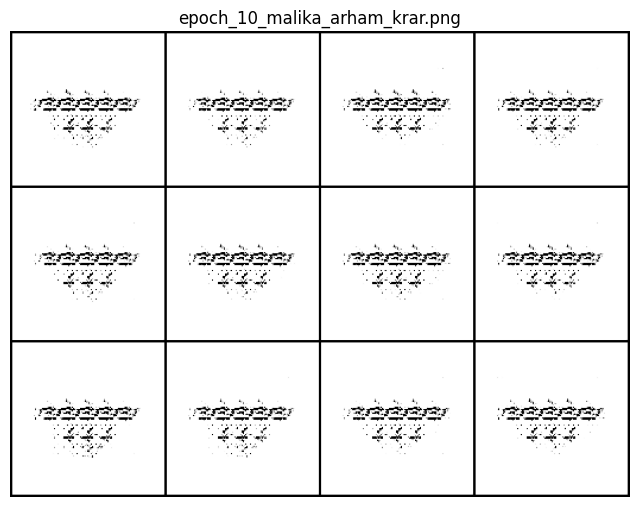

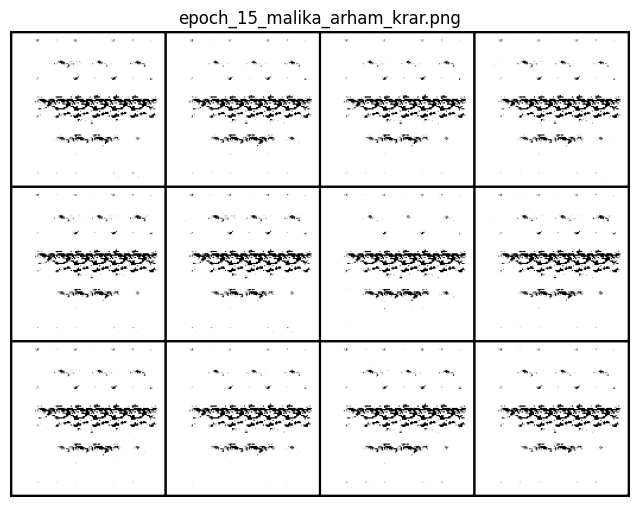

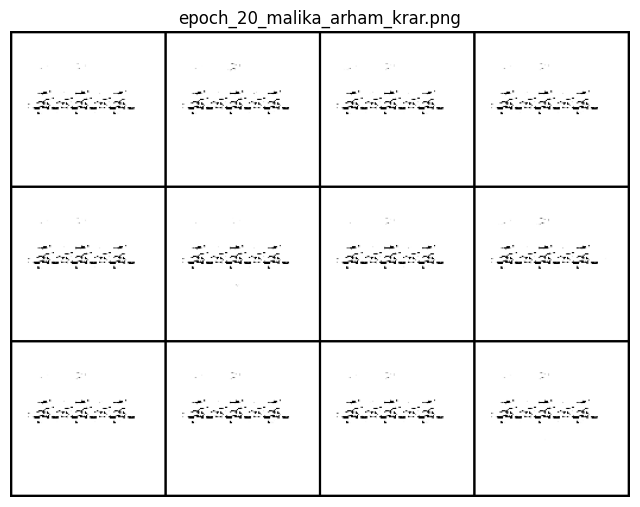

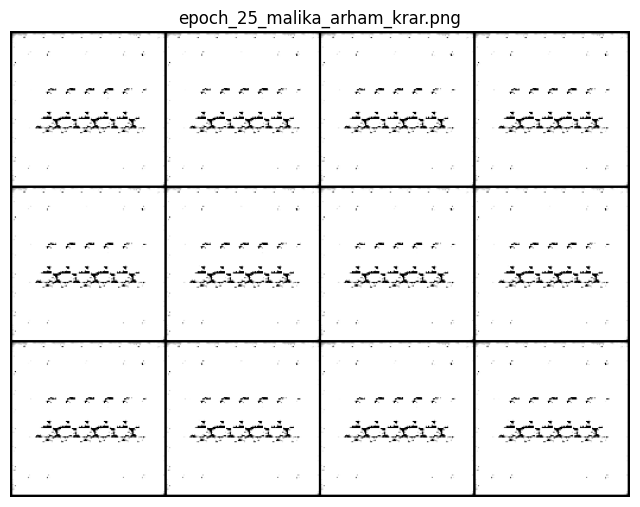

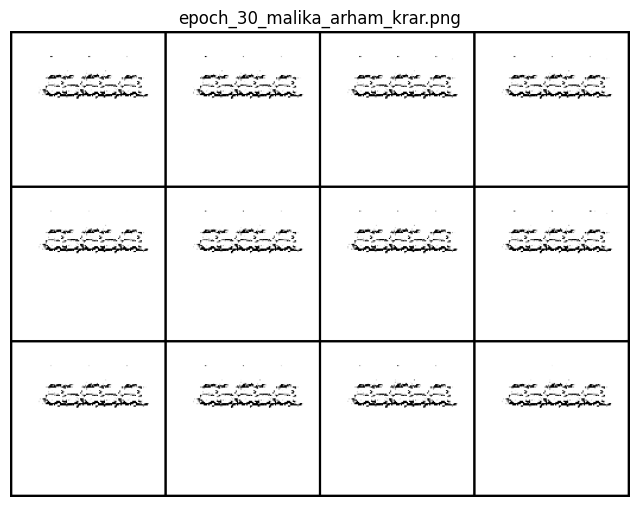

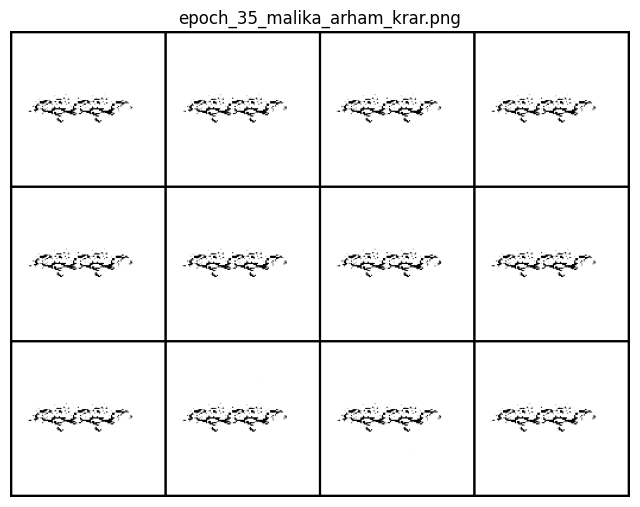

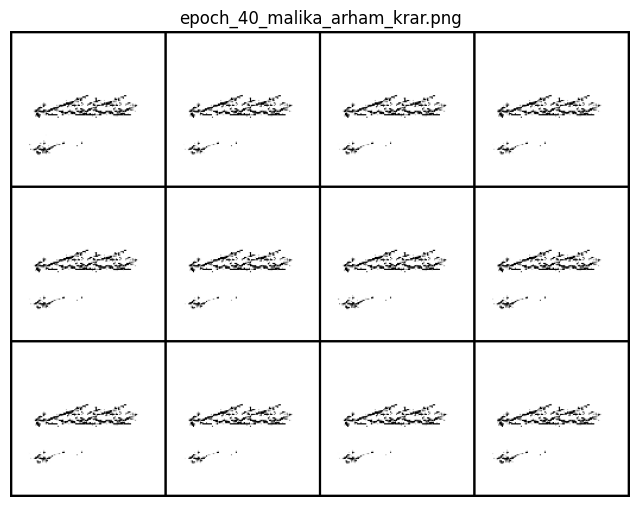

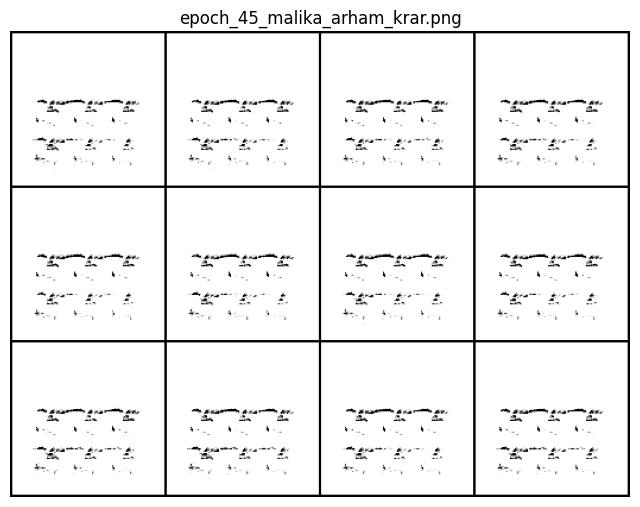

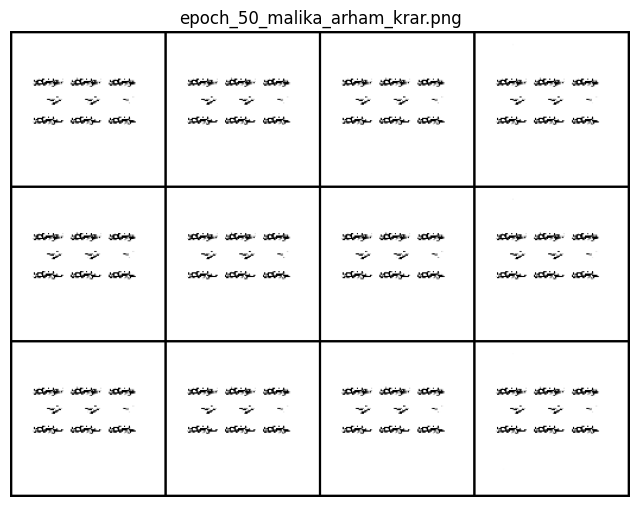

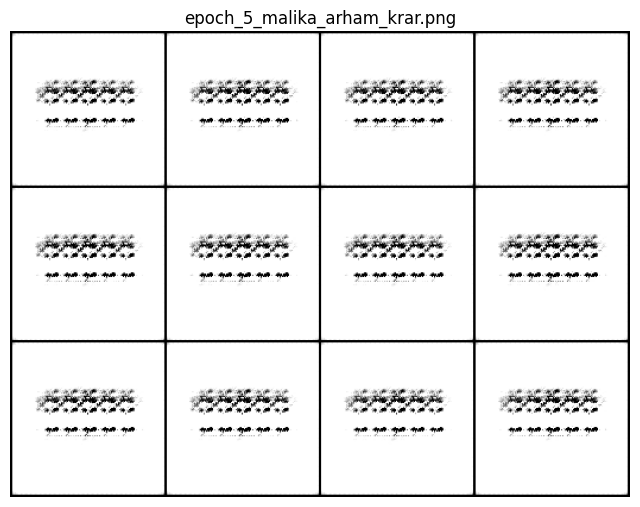

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageEnhance

# Path where your samples are saved
sample_dir = "/content/drive/MyDrive/GPDS 1-150/samples_acgan"

# Get all sample files sorted by name
sample_files = sorted([f for f in os.listdir(sample_dir) if f.endswith('.png')])

# Display images with enhancement
for file in sample_files:
    img_path = os.path.join(sample_dir, file)
    img = Image.open(img_path)

    # Enhance contrast and brightness
    enhancer_contrast = ImageEnhance.Contrast(img)
    img = enhancer_contrast.enhance(1.5)  # increase contrast (1.0 = original)

    enhancer_brightness = ImageEnhance.Brightness(img)
    img = enhancer_brightness.enhance(1.2)  # increase brightness (1.0 = original)

    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(file)
    plt.show()


#**Test The Model**

In [2]:
# Take name input from user
user_name = input("Enter the name for which to generate signatures: ")

# Number of samples per name
n_samples = 5

# Generate signatures
sample_signatures_name(G, [user_name], n_per_name=n_samples, ds=ds)


#**Load The Model & Run**

✅ Generator loaded successfully!
Enter names separated by comma: Arham
✅ Saved 5 synthetic signatures for ['Arham'] at /content/drive/MyDrive/GPDS 1-150/samples_acgan/sample_Arham.png


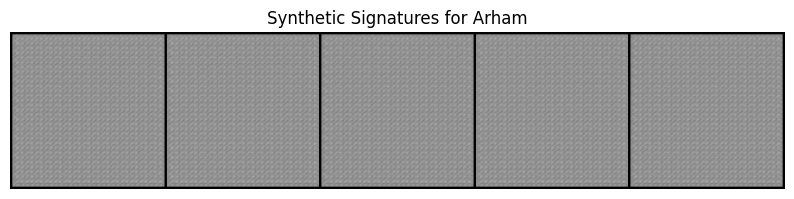

In [30]:
# --- Config ---
CHECKPOINT_PATH = "/content/drive/MyDrive/GPDS 1-150/checkpoints_acgan/G_final.pth"
DATA_ROOT = "/content/drive/MyDrive/GPDS 1-150/Final_Dataset"
Z_DIM = 128
IMG_SIZE = 128
NAME_EMBED_DIM = 128  # must match training exactly

# --- Dataset ---
ds = SignatureDataset(root=DATA_ROOT, split="test", img_size=IMG_SIZE)

# --- Override _encode_name to use correct embedding size ---
# (ensure ds.gru.hidden_size = NAME_EMBED_DIM)
ds.gru = torch.nn.GRU(ds.char_embedding.embedding_dim, NAME_EMBED_DIM, batch_first=True)
ds.gru.eval()

# --- Initialize Generator exactly as in training ---
G = Generator(Z_DIM, name_embed_dim=NAME_EMBED_DIM, img_size=IMG_SIZE).to(DEVICE)

# --- Load checkpoint ---
state_dict = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
G.load_state_dict(state_dict)
G.eval()
print("✅ Generator loaded successfully!")

# --- User input ---
user_input = input("Enter names separated by comma: ")
names = [name.strip() for name in user_input.split(",") if name.strip()]

# --- Generate signatures ---
import matplotlib.pyplot as plt
from torchvision import utils

def sample_signatures_name(G, names, n_per_name=5, ds=None):
    all_name_embs = []
    for name in names:
        name_emb = ds._encode_name(name.lower())  # 128-dim
        all_name_embs.append(name_emb.unsqueeze(0).repeat(n_per_name, 1))
    all_name_embs = torch.cat(all_name_embs, dim=0).to(DEVICE)

    z = torch.randn(len(all_name_embs), Z_DIM, device=DEVICE)
    with torch.no_grad():
        imgs = G(z, all_name_embs).cpu()
    imgs = (imgs + 1) / 2  # [-1,1] -> [0,1]

    # Save image grid
    filename = f"{SAMPLE_DIR}/sample_{'_'.join(names)}.png"
    utils.save_image(utils.make_grid(imgs, nrow=n_per_name, padding=2), filename)
    print(f"✅ Saved {len(names)*n_per_name} synthetic signatures for {names} at {filename}")

    # --- Display images ---
    grid_img = utils.make_grid(imgs, nrow=n_per_name, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # CxHxW -> HxWxC
    plt.axis('off')
    plt.title(f"Synthetic Signatures for {', '.join(names)}")
    plt.show()

    return imgs

# --- Run for user input ---
if names:
    sample_signatures_name(G, names, n_per_name=5, ds=ds)

